In [9]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.stats import gmean
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import warnings


In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [45]:
from monaco_distribution_pipeline import main
from utils import (
    loader,
    load_data,
    preprocess_df_distribution,
    log_ratio_geometric_transform
)

## 1. Only with >= 2021/09 data

### (1) Data preparation

In [57]:
CURRENT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
SQL_DIR = os.path.join(CURRENT_DIR, "sql")

rs = loader()

df_distribution = load_data(
    sql_path=os.path.join(SQL_DIR, 'monaco_distribution.sql'), 
    loader=rs)

In [62]:
#df_distribution.info()

# Preprocess data
df_distribution_subset = preprocess_df_distribution(df_distribution)

# Log ratio geometric transformation
#df_distribution = log_ratio_geometric_transform(df_distribution)


In [63]:
df_distribution

,trip_end_month,monaco_bin,paid_days,distribution_full,total_paid_days_known,distribution
0,2017-01-01,A1,2997.0,0.0511,7983.0,0.375423
1,2017-01-01,A2,2125.0,0.0362,7983.0,0.266191
2,2017-01-01,A3,944.0,0.0161,7983.0,0.118251
3,2017-01-01,B,1192.0,0.0203,7983.0,0.149317
4,2017-01-01,C,384.0,0.0065,7983.0,0.048102
...,...,...,...,...,...,...
832,2024-09-01,C,190344.0,0.1038,1752006.0,0.108643
833,2024-09-01,D,145448.0,0.0793,1752006.0,0.083018
834,2024-09-01,E,111288.0,0.0607,1752006.0,0.063520
835,2024-09-01,F,118651.0,0.0647,1752006.0,0.067723


### (2) Apply time series model for each segment with log ratio transformation

* Use between 2022 and 2023 data to forecast 2024

In [ ]:
# Function to find the optimal order and seasonal order
def find_optimal_sarima_order(segment_df, p=range(0, 3), d=range(0, 3), q=range(0, 3), 
                                  sp=range(0, 2), sd=range(0, 2), sq=range(0, 2), s=12):
    best_avg_mae = np.inf
    validation_window = 3
    initial_train_window = len(segment_df) - 4 * validation_window
    best_order = None
    best_seasonal_order = None
    for param in [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]:
        for seasonal_param in [(x[0], x[1], x[2], s) for x in list(itertools.product(sp, sd, sq))]:
            errors = []

            for i in range(4):
                train_end = initial_train_window + i * validation_window
                train_data = segment_df[:train_end]
                val_data = segment_df[train_end:train_end + validation_window]

            try:
                model = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=seasonal_param)
                                                    #enforce_stationarity=False,
                                                    #enforce_invertibility=False)
                results = model.fit(disp=False)
                # Compute mean absolute error
                # forecast = results.get_prediction(start=segment_df.index[0], end=segment_df.index[-1])
                # mse = ((forecast.predicted_mean - segment_df['log_ratio_geo_distribution']) ** 2).mean()
                forecast = results.forecast(steps=validation_window)
                mae = mean_absolute_error(val_data, forecast)
                errors.append(mae)
            except:
                continue
        
            if len(errors) > 0:
                avg_error = np.mean(errors)
                if avg_error < best_avg_mae:
                    best_avg_mae = avg_error
                    best_order = param
                    best_seasonal_order = seasonal_param
            
    return best_order, best_seasonal_order




# Function to fit SARIMA model for each segment
def fit_sarima(df, segment):
    segment_df = df[df['monaco_bin'] == segment].set_index('trip_end_month')
    # Find optimal order and seasonal order
    optimal_order, optimal_seasonal_order = find_optimal_sarima_order(segment_df['log_ratio_geo_distribution'])

    # Fit SARIMA model with optimal parameters
    test_window = 3
    train_window = len(segment_df) - test_window
    model = sm.tsa.statespace.SARIMAX(segment_df['log_ratio_geo_distribution'][:train_window],
                                    order=optimal_order,
                                    seasonal_order=optimal_seasonal_order)
                                      #enforce_stationarity=False,
                                      #enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

# Get unique segments
segments = df_distribution_subset['monaco_bin'].unique()

# Fit SARIMA model for each segment and plot the results
sarima_results = {}
forecast_df = pd.DataFrame()
for segment in segments:
    warnings.filterwarnings("ignore")

    results = fit_sarima(df_distribution_subset, segment)
    sarima_results[segment] = results
    #print(f"SARIMA model for segment {segment}:")
    #print(results.summary())
    forecast = results.get_forecast(steps=3).predicted_mean
    forecast = forecast.reset_index()
    forecast.columns = ['trip_end_month', 'forecast']
    forecast['segment'] = segment
    forecast_df = pd.concat([forecast_df, forecast], ignore_index=True)
    
forecast_df['exp_forecast'] = np.exp(forecast_df['forecast'])
forecast_df['sum_exp_forecast'] = forecast_df.groupby('trip_end_month')['exp_forecast'].transform('sum')
forecast_df['inv_forecast'] = forecast_df['exp_forecast'] / forecast_df['sum_exp_forecast']


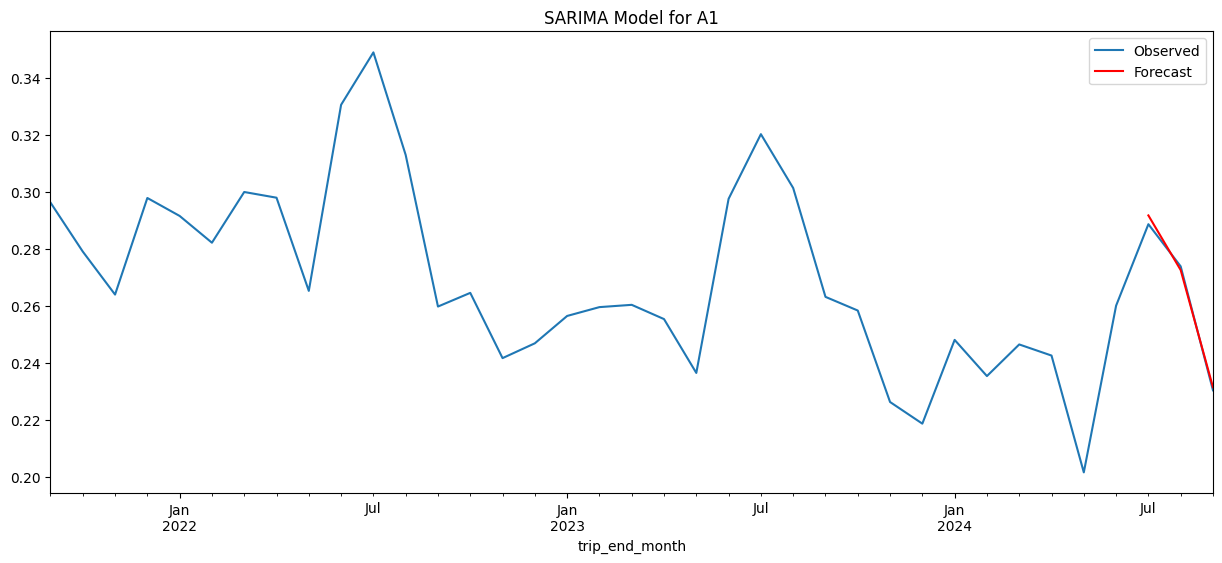

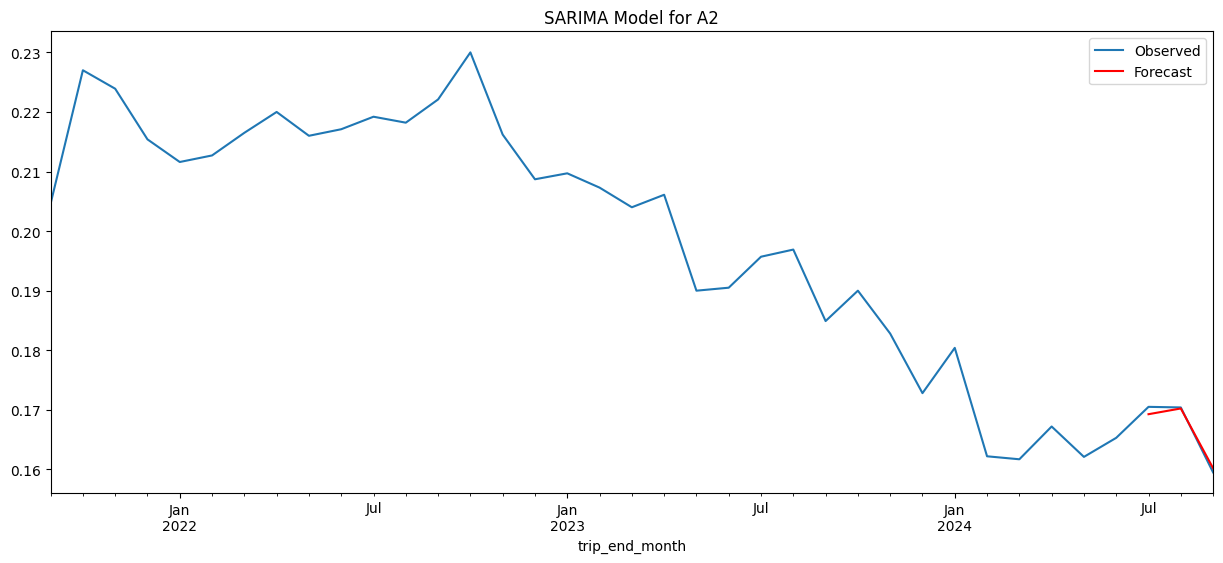

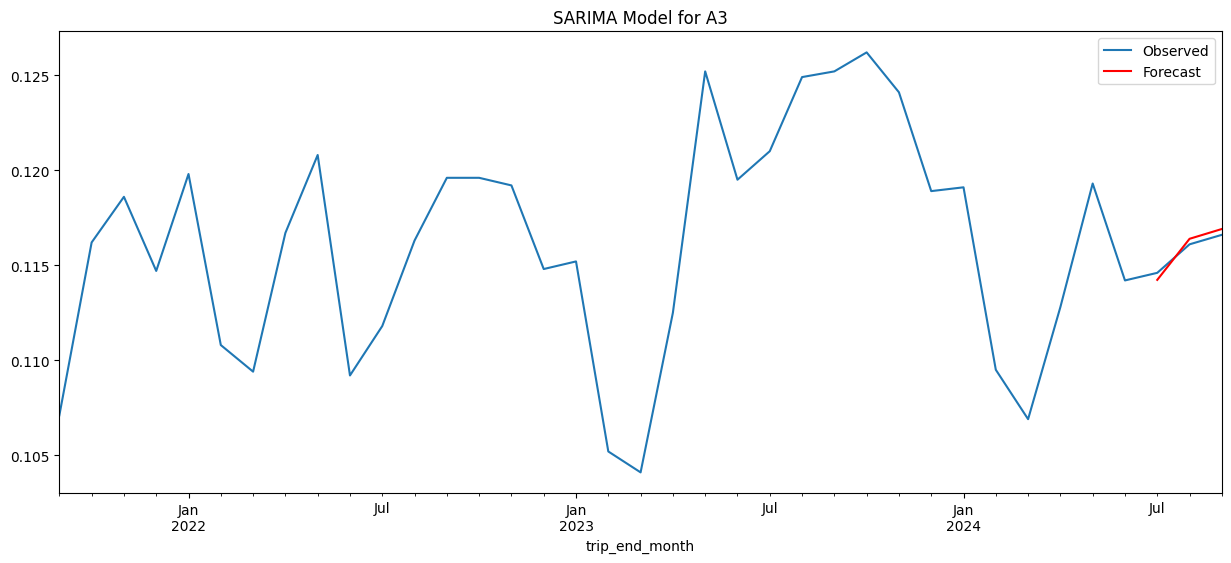

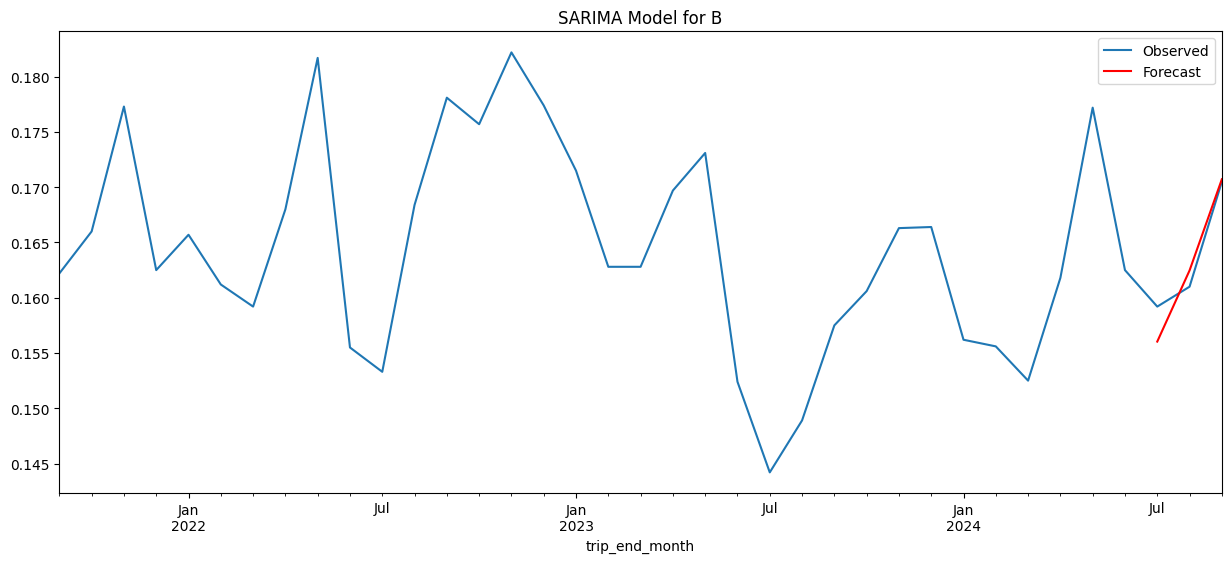

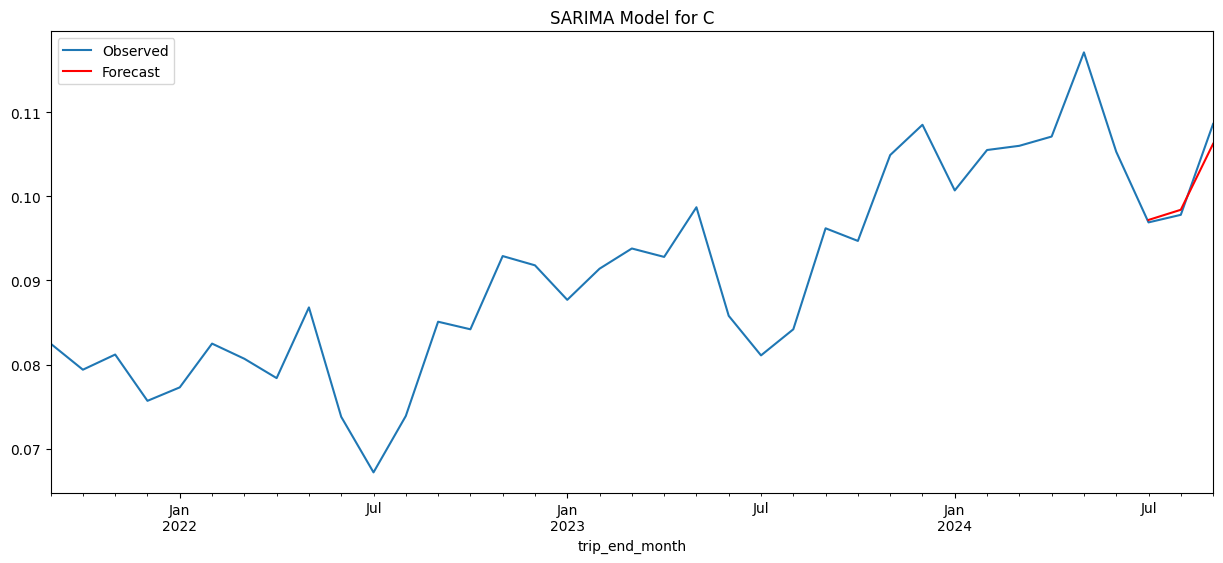

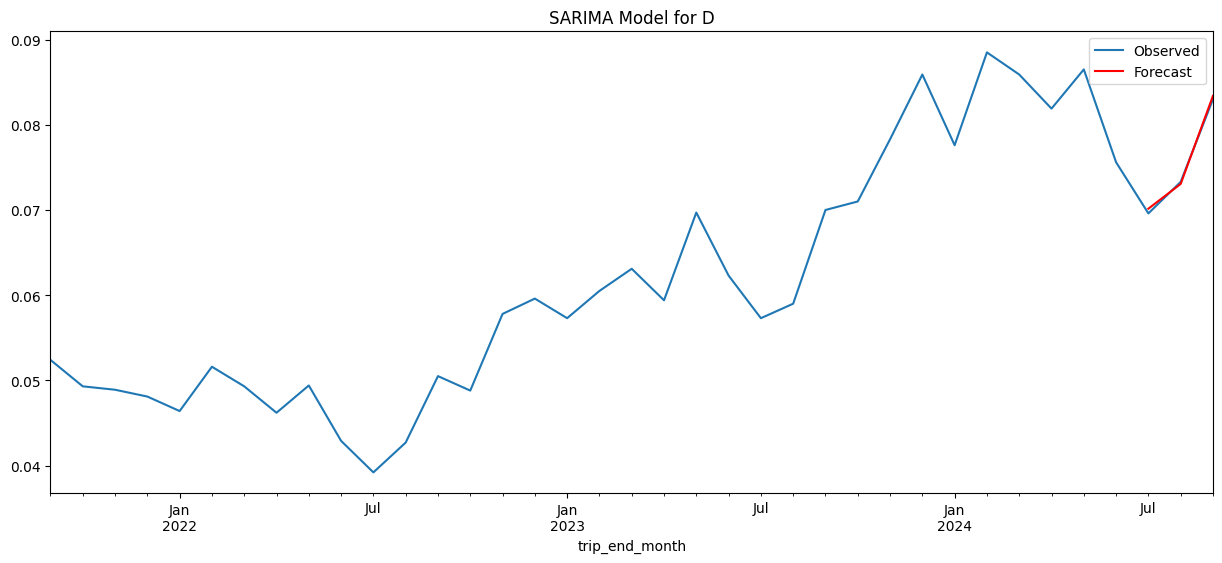

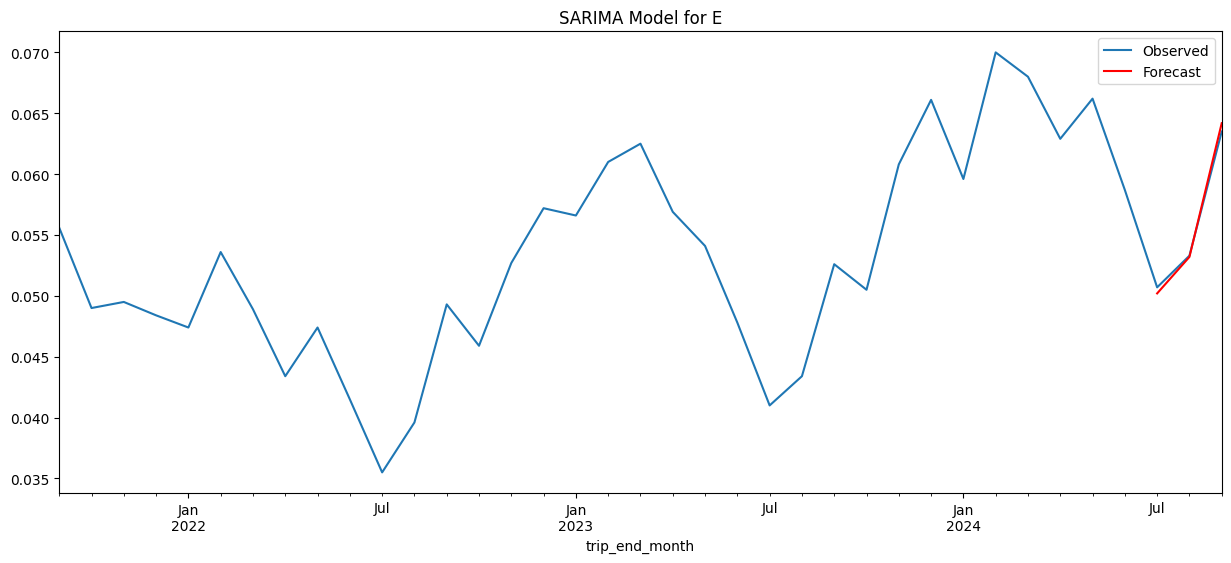

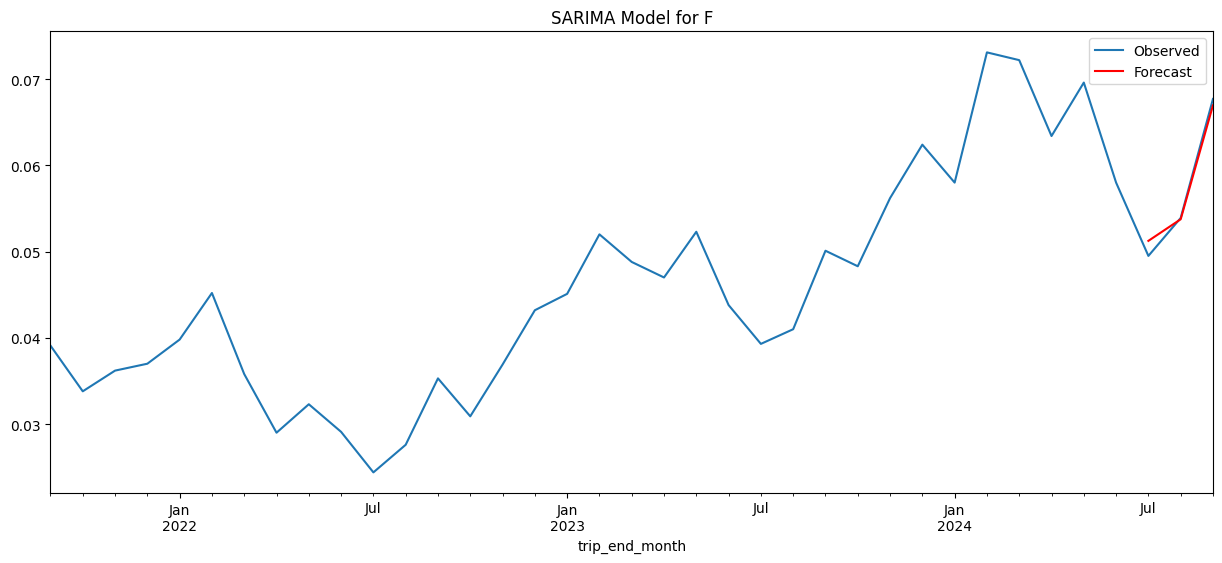

In [22]:
for segment in segments:    
    # Plotting the results
    segment_df = df_distribution_subset[df_distribution_subset['monaco_bin'] == segment].set_index('trip_end_month')
    segment_df['distribution'].plot(label='Observed', figsize=(15, 6))
    segment_forecast_df = forecast_df[forecast_df['segment'] == segment].set_index('trip_end_month')
    segment_forecast_df.inv_forecast.plot(label='Forecast', color='red')
    plt.title(f'SARIMA Model for {segment}')
    plt.legend()
    plt.show()

### (3) Apply Time Series Model to raw data

In [ ]:
forecast_test_df = main()

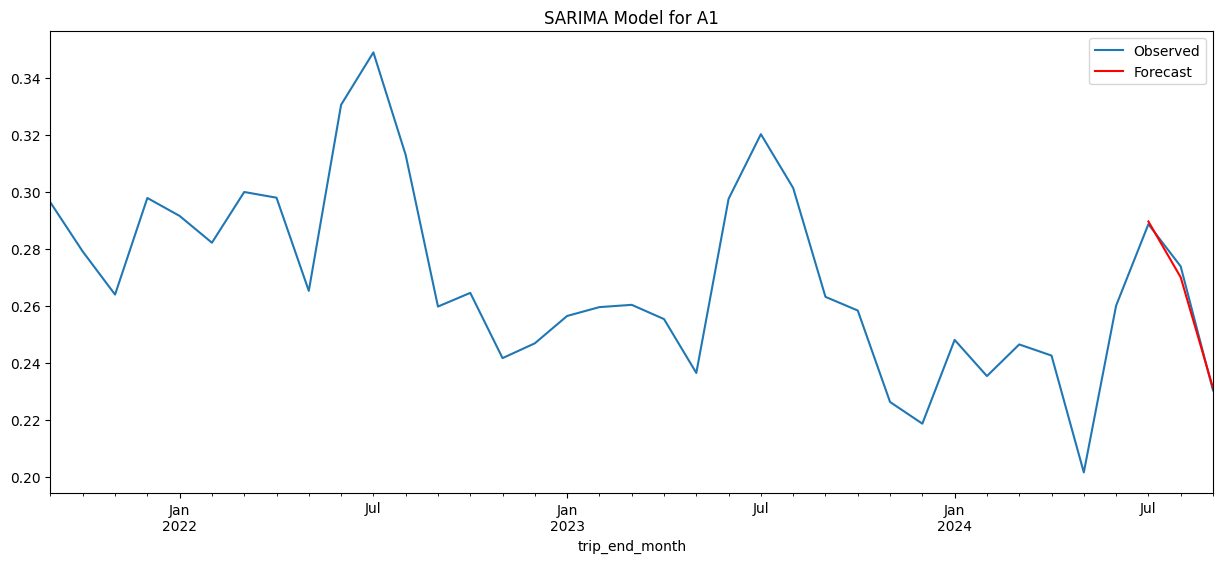

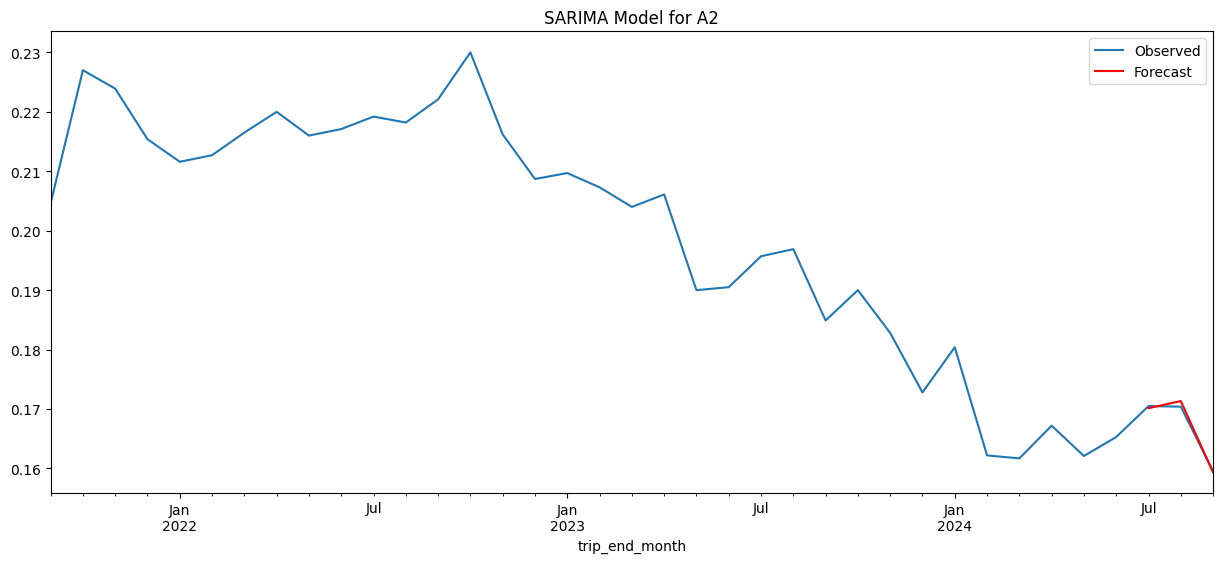

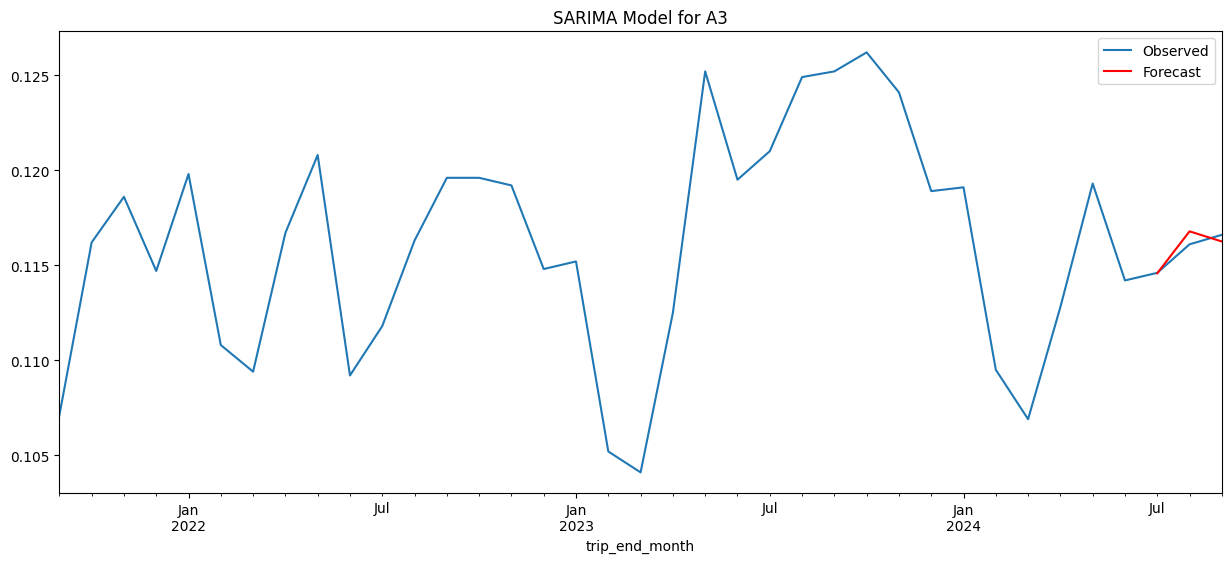

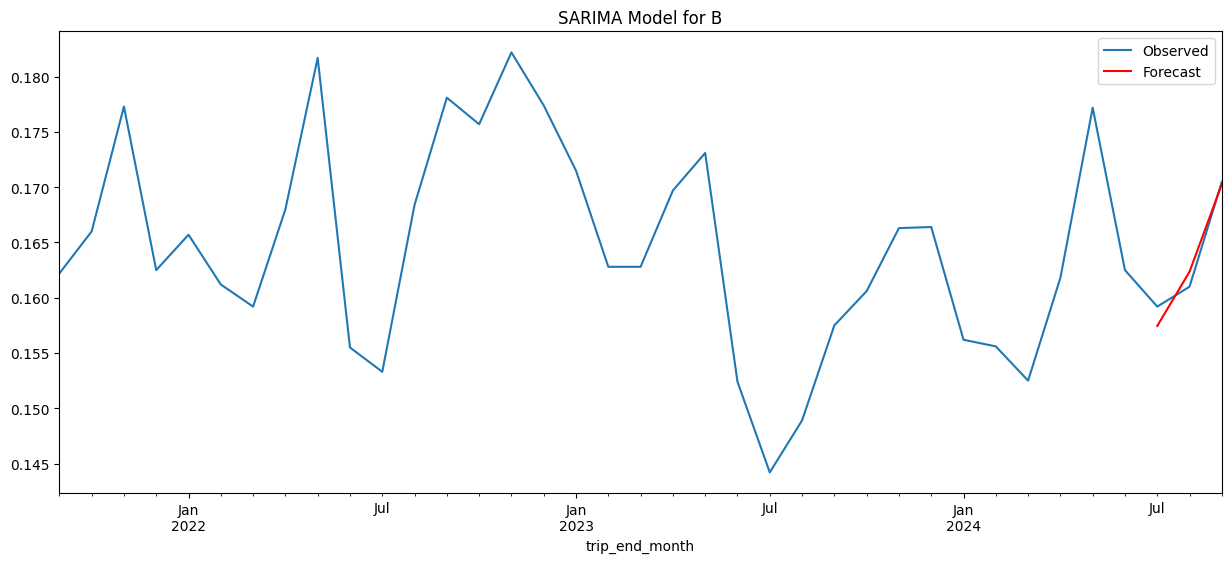

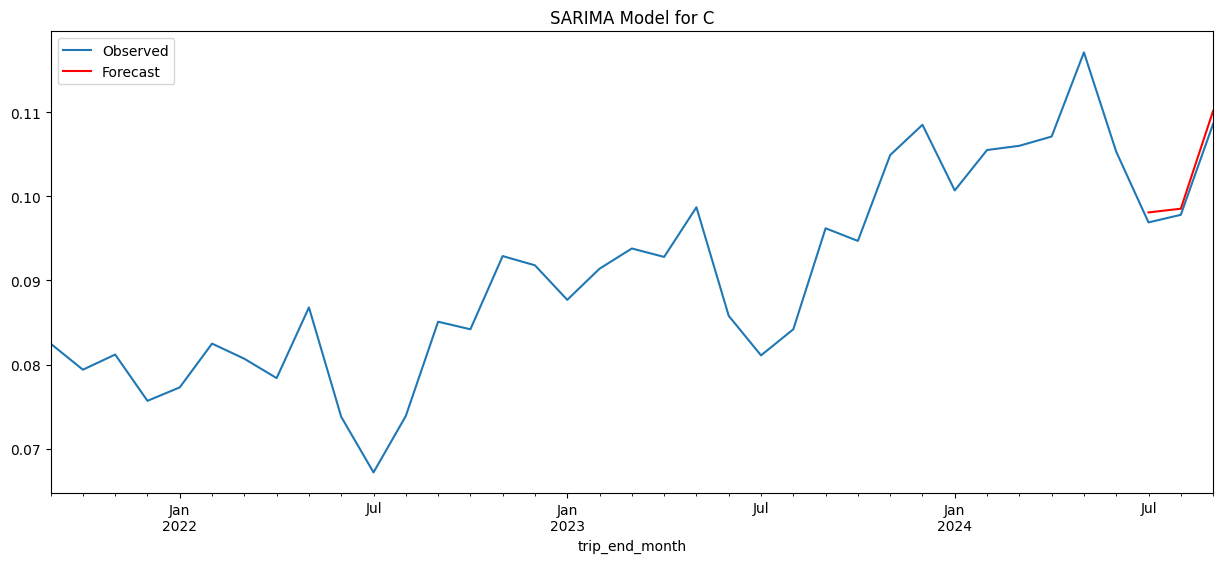

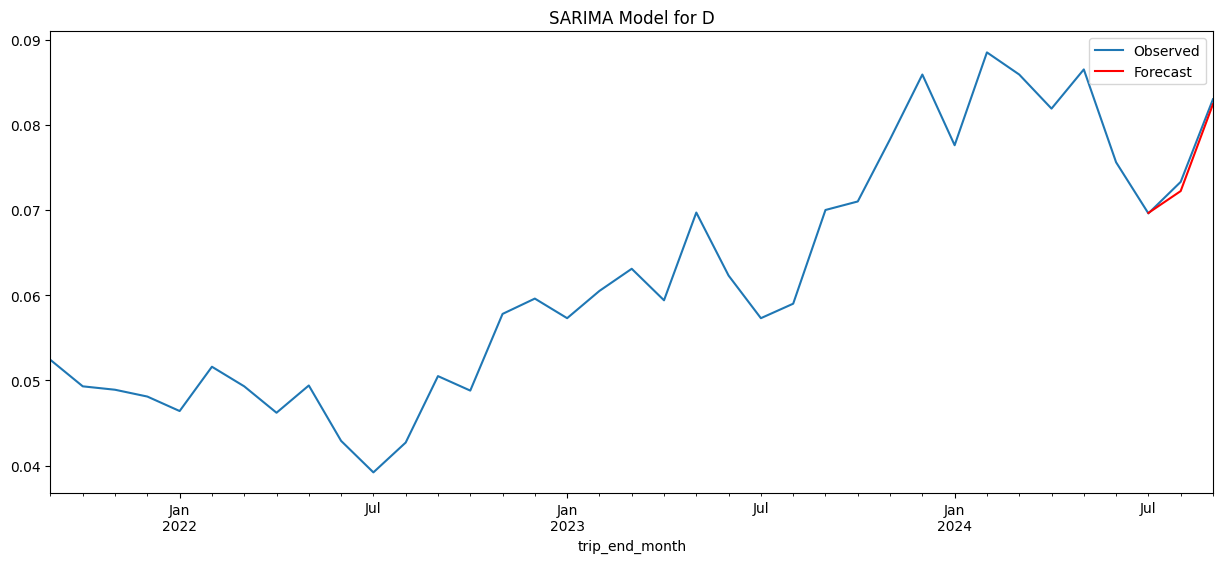

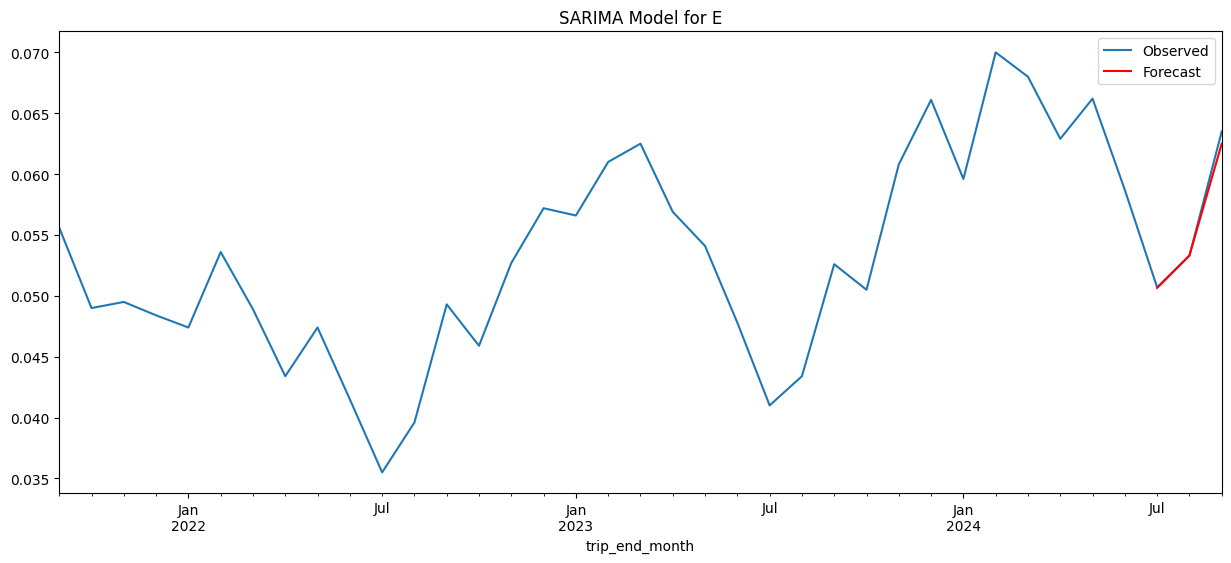

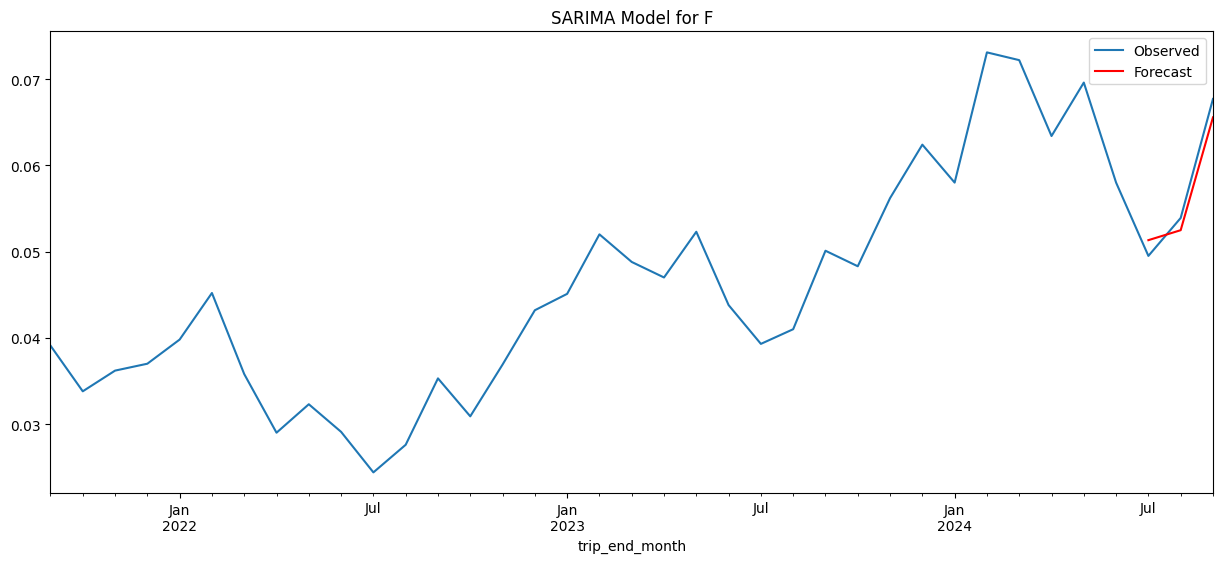

In [43]:
for segment in segments:   
    # Plotting the results
    segment_df = df_distribution_subset[df_distribution_subset['monaco_bin'] == segment].set_index('trip_end_month')
    segment_df['distribution'].plot(label='Observed', figsize=(15, 6))
    segmenf_forecast_df = forecast_test_df[forecast_test_df['monaco_bin'] == segment].set_index('trip_end_month')
    segmenf_forecast_df.distribution_forecast.plot(label='Forecast', color='red')
    plt.title(f'SARIMA Model for {segment}')
    plt.legend()
    plt.show()